In [1]:
import io
import os
import json
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Feature Engineering

We will generate some new domain-specific features out of the existing ones.
- ABC Analysis (Product Classification by Value)
- FMR Analysis (Product Classification by Selling Frequency)
- Exogenous Variables (Holidays, CPI, Shopping Seasons)
- Time Series Features (Lags, Moving Averages)
- Temporal Features (Date-based)
- Outlier Identification & Removal

## 1. Load Data

In [2]:
# Load data from previous notebook
with zipfile.ZipFile('data/3_enriched_data.zip', 'r') as zip_ref:
    with zip_ref.open('enriched_sales_data.csv') as csv_file:
        df = pd.read_csv(csv_file, low_memory=False)

# Convert date and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['location_id', 'product_id', 'date']).reset_index(drop=True)

print(f'Dataset: {df.shape[0]:,} records × {df.shape[1]} columns')
print(f'Date range: {df["date"].min().date()} to {df["date"].max().date()}')
print(f'Products: {df["product_id"].nunique():,} | Locations: {df["location_id"].nunique():,}')

Dataset: 589,340 records × 17 columns
Date range: 2023-01-01 to 2024-01-30
Products: 67 | Locations: 107


## 2. ABC Analysis
Classify products by their **value contribution** (total revenue) using custom proportions (instead of Pareto).

- **A items** (15%): Highest value contributors (high revenue)
- **B items** (20%): Medium value contributors
- **C items** (65%): Lowest value contributors


Category  Products  Total Revenue  Total Volume  % Products  % Revenue  % Volume
       A        10   142495592.68     1678914.0        14.9       53.5      47.2
       B        13    99424110.93     1801044.0        19.4       37.3      50.7
       C        44    24284120.30       73561.0        65.7        9.1       2.1


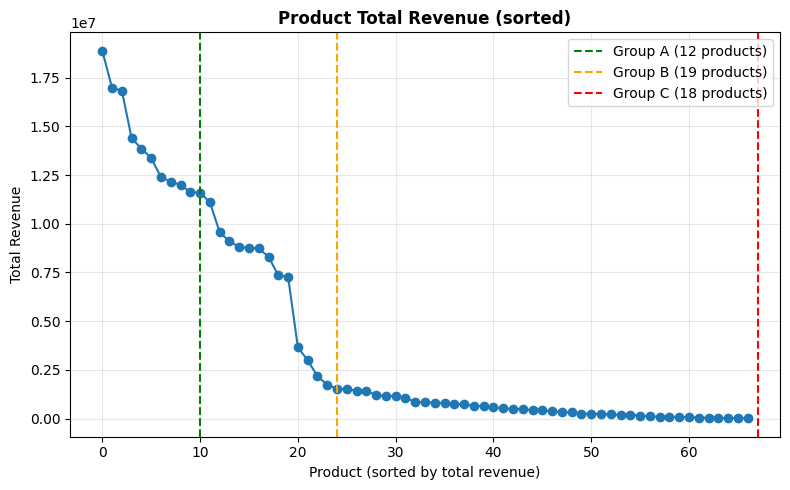

In [3]:
# Use existing revenue column
product_value = df.groupby('product_id').agg({
    'revenue': 'sum',
    'units_sold': 'sum'
}).reset_index()

product_value.columns = ['product_id', 'total_revenue', 'total_units_sold']
product_value = product_value.sort_values('total_revenue', ascending=False).reset_index(drop=True)

# Assign ABC categories based on value (Pareto 20-40-40)
product_value['rank_pct'] = (product_value.index + 1) / len(product_value) * 100
product_value['abc'] = pd.cut(
    product_value['rank_pct'],
    bins=[0, 15, 35, 100],
    labels=['A', 'B', 'C']
)

# Merge back to main dataframe
df = df.merge(product_value[['product_id', 'abc']], on='product_id', how='left')

# Summary
abc_summary = product_value.groupby('abc').agg({
    'product_id': 'count',
    'total_revenue': 'sum',
    'total_units_sold': 'sum'
}).reset_index()

abc_summary.columns = ['Category', 'Products', 'Total Revenue', 'Total Volume']
abc_summary['% Products'] = (abc_summary['Products'] / len(product_value) * 100).round(1)
abc_summary['% Revenue'] = (abc_summary['Total Revenue'] / product_value['total_revenue'].sum() * 100).round(1)
abc_summary['% Volume'] = (abc_summary['Total Volume'] / product_value['total_units_sold'].sum() * 100).round(1)

print('\n' + abc_summary.to_string(index=False))

# Plot the ABC classification results
plt.figure(figsize=(8, 5))
plt.plot(product_value['total_revenue'].values, marker='o')
plt.title('Product Total Revenue (sorted)', fontweight='bold')
plt.xlabel('Product (sorted by total revenue)')
plt.ylabel('Total Revenue')
plt.axvline(x=10, color='green', linestyle='--', label='Group A (12 products)')
plt.axvline(x=24, color='orange', linestyle='--', label='Group B (19 products)')
plt.axvline(x=67, color='red', linestyle='--', label='Group C (18 products)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. FMR Analysis
Classify products by selling frequency using reverted Pareto distribution.

- **Fast movers** (40%): Sell most frequently
- **Medium movers** (40%): Moderate selling frequency
- **Rare movers** (20%): Sell least frequently


Category  Products  Avg Frequency (%)  Total Volume  % Products
    Fast        26          99.844206     3495246.0        38.8
  Medium        27          84.547586       54494.0        40.3
    Rare        14          29.168174        3779.0        20.9


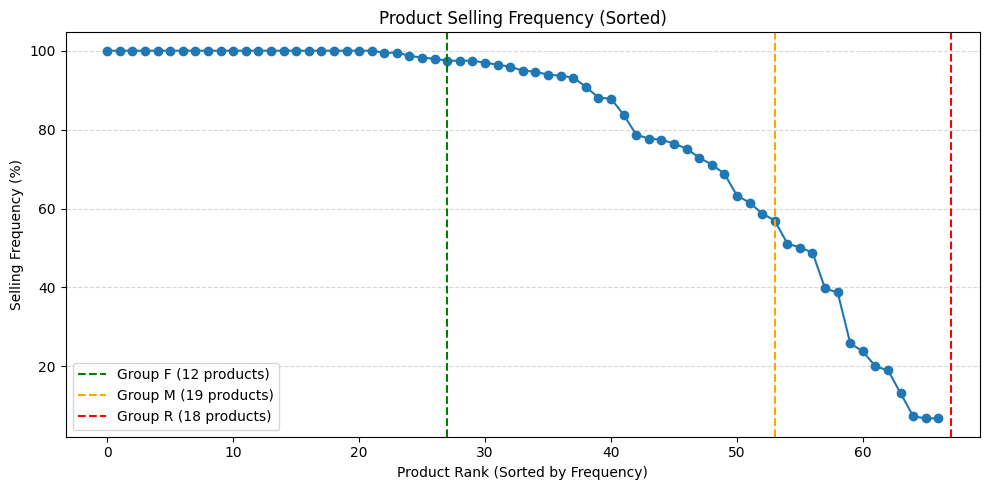

In [4]:
# Calculate selling frequency per product
total_days = (df['date'].max() - df['date'].min()).days + 1
product_frequency = df[df['units_sold'] > 0].groupby('product_id').agg({
    'date': 'nunique',
    'units_sold': 'sum'
}).reset_index()
product_frequency.columns = ['product_id', 'days_with_sales', 'total_units_sold']
product_frequency['selling_frequency'] = (product_frequency['days_with_sales'] / total_days * 100)
product_frequency = product_frequency.sort_values('selling_frequency', ascending=False).reset_index(drop=True)

# Assign FMR categories (Pareto 20-40-40)
product_frequency['rank_pct'] = (product_frequency.index + 1) / len(product_frequency) * 100
product_frequency['fmr'] = pd.cut(
    product_frequency['rank_pct'],
    bins=[0, 40, 80, 100],
    labels=['Fast', 'Medium', 'Rare']
)

# Merge back
df = df.merge(
    product_frequency[['product_id', 'fmr', 'selling_frequency', 'days_with_sales']], 
    on='product_id', 
    how='left'
)

# Summary
fmr_summary = product_frequency.groupby('fmr').agg({
    'product_id': 'count',
    'selling_frequency': 'mean',
    'total_units_sold': 'sum'
}).reset_index()
fmr_summary.columns = ['Category', 'Products', 'Avg Frequency (%)', 'Total Volume']
fmr_summary['% Products'] = (fmr_summary['Products'] / len(product_frequency) * 100).round(1)

print('\n' + fmr_summary.to_string(index=False))

# Plot the FMR classification results
plt.figure(figsize=(10,5))
plt.plot(product_frequency['selling_frequency'].values, marker='o')
plt.title('Product Selling Frequency (Sorted)')
plt.xlabel('Product Rank (Sorted by Frequency)')
plt.ylabel('Selling Frequency (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.axvline(x=27, color='green', linestyle='--', label='Group F (12 products)')
plt.axvline(x=53, color='orange', linestyle='--', label='Group M (19 products)')
plt.axvline(x=67, color='red', linestyle='--', label='Group R (18 products)')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Exogenous Variables

External factors that influence demand but are not part of historical sales data.

### 4.1 Holidays

US Federal holidays and related features for 2022-2024.

In [5]:
# US Federal Holidays 2022-2024
us_holidays = pd.to_datetime([
    '2022-01-01', '2022-01-17', '2022-02-21', '2022-05-30', '2022-06-20', '2022-07-04',
    '2022-09-05', '2022-10-10', '2022-11-11', '2022-11-24', '2022-12-26',
    '2023-01-02', '2023-01-16', '2023-02-20', '2023-05-29', '2023-06-19', '2023-07-04',
    '2023-09-04', '2023-10-09', '2023-11-10', '2023-11-23', '2023-12-25',
    '2024-01-01', '2024-01-15', '2024-02-19', '2024-05-27', '2024-06-19', '2024-07-04',
    '2024-09-02', '2024-10-14', '2024-11-11', '2024-11-28', '2024-12-25'
])

# Basic holiday features
df['is_holiday'] = df['date'].isin(us_holidays).astype(int)

# OPTIMIZED: Vectorized holiday distance calculation using merge_asof
# Create a holiday dataframe for merge_asof
holiday_df = pd.DataFrame({'holiday_date': us_holidays}).sort_values('holiday_date')

# For days_to_holiday: find next holiday after each date
df_sorted = df[['date']].sort_values('date').reset_index()
df_sorted = pd.merge_asof(
    df_sorted,
    holiday_df,
    left_on='date',
    right_on='holiday_date',
    direction='forward'
)
df_sorted['days_to_holiday'] = (df_sorted['holiday_date'] - df_sorted['date']).dt.days
df_sorted['days_to_holiday'] = df_sorted['days_to_holiday'].fillna(365).astype(int)
df = df.merge(df_sorted[['index', 'days_to_holiday']], left_index=True, right_on='index', how='left').drop('index', axis=1)

# For days_from_holiday: find previous holiday before each date
df_sorted = df[['date']].sort_values('date').reset_index()
df_sorted = pd.merge_asof(
    df_sorted,
    holiday_df,
    left_on='date',
    right_on='holiday_date',
    direction='backward'
)
df_sorted['days_from_holiday'] = (df_sorted['date'] - df_sorted['holiday_date']).dt.days
df_sorted['days_from_holiday'] = df_sorted['days_from_holiday'].fillna(365).astype(int)
df = df.merge(df_sorted[['index', 'days_from_holiday']], left_index=True, right_on='index', how='left').drop('index', axis=1)

df['near_holiday'] = ((df['days_to_holiday'] <= 3) | (df['days_from_holiday'] <= 3)).astype(int)

# Shopping seasons
df['is_black_friday_week'] = ((df['date'].dt.month == 11) & (df['date'].dt.day >= 20)).astype(int)
df['is_christmas_season'] = ((df['date'].dt.month == 12) & (df['date'].dt.day <= 24)).astype(int)
df['is_back_to_school'] = ((df['date'].dt.month >= 8) & (df['date'].dt.month <= 9)).astype(int)

print(f'  [OK] is_holiday: {df["is_holiday"].sum():,} holiday dates')
print(f'  [OK] near_holiday: {df["near_holiday"].sum():,} dates near holidays')
print(f'  [OK] Shopping seasons: Black Friday, Christmas, Back-to-School')

  [OK] is_holiday: 19,396 holiday dates
  [OK] near_holiday: 132,788 dates near holidays
  [OK] Shopping seasons: Black Friday, Christmas, Back-to-School


### 4.2 CPI (Consumer Price Index)

Macroeconomic indicator from BLS API showing inflation trends.

In [6]:
def fetch_bls_cpi(start_year, end_year, cache_file='data\cpi_cache.csv'):
    """Fetch CPI-U (All items) from BLS API using a local CSV cache"""
    # First, check for a CSV cache file covering the full requested period
    if os.path.exists(cache_file):
        cpi_cache = pd.read_csv(cache_file, parse_dates=['date'])
        min_cache_year = cpi_cache['date'].dt.year.min()
        max_cache_year = cpi_cache['date'].dt.year.max()
        if min_cache_year <= start_year and max_cache_year >= end_year:
            # Use only the required range
            subset = cpi_cache[(cpi_cache['date'].dt.year >= start_year) & (cpi_cache['date'].dt.year <= end_year)].copy()
            if not subset.empty:
                return subset.reset_index(drop=True)
    
    url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
    data = json.dumps({
        "seriesid": ['CUUR0000SA0'],  # CPI-U
        "startyear": str(start_year),
        "endyear": str(end_year)
    })

    try:
        response = requests.post(url, data=data, headers={'Content-type': 'application/json'}, timeout=30)
        if response.status_code == 200:
            json_data = response.json()
            if json_data['status'] == 'REQUEST_SUCCEEDED':
                records = []
                for item in json_data['Results']['series'][0]['data']:
                    date = pd.Timestamp(year=int(item['year']), month=int(item['period'][1:]), day=1)
                    records.append({'date': date, 'cpi': float(item['value'])})
                df_cpi = pd.DataFrame(records)
                # Save or update the cache
                if os.path.exists(cache_file):
                    # Append new rows if not present
                    cpi_cache = pd.read_csv(cache_file, parse_dates=['date'])
                    combined = pd.concat([cpi_cache, df_cpi]).drop_duplicates(subset=['date']).reset_index(drop=True)
                    combined = combined.sort_values('date')
                    combined.to_csv(cache_file, index=False)
                else:
                    df_cpi.sort_values('date').to_csv(cache_file, index=False)
                return df_cpi
    except Exception as e:
        pass
    return None

# Fetch and merge CPI
if 'cpi' not in df:
    cpi_data = fetch_bls_cpi(2022, 2024)

    df['year_month'] = df['date'].dt.to_period('M')
    cpi_data['year_month'] = cpi_data['date'].dt.to_period('M')

    # Merge CPI
    df = df.merge(cpi_data[['year_month', 'cpi']], on='year_month', how='left')

    # Calculate inflation rates
    cpi_monthly = cpi_data.set_index('year_month')['cpi']
    cpi_monthly = cpi_monthly.sort_index() # Sort by date in chronological order.
    df['cpi_mom_change'] = df['year_month'].map(cpi_monthly.pct_change() * 100)
    df['cpi_yoy_change'] = df['year_month'].map(cpi_monthly.pct_change(periods=12) * 100)

    df = df.drop('year_month', axis=1)
    df['cpi'] = df['cpi'].ffill()
    df['cpi_mom_change'] = df['cpi_mom_change'].fillna(0)
    df['cpi_yoy_change'] = df['cpi_yoy_change'].ffill()

print(f'  [OK] Avg inflation (YoY): {df["cpi_yoy_change"].mean():.2f}%')

  [OK] Avg inflation (YoY): 4.05%


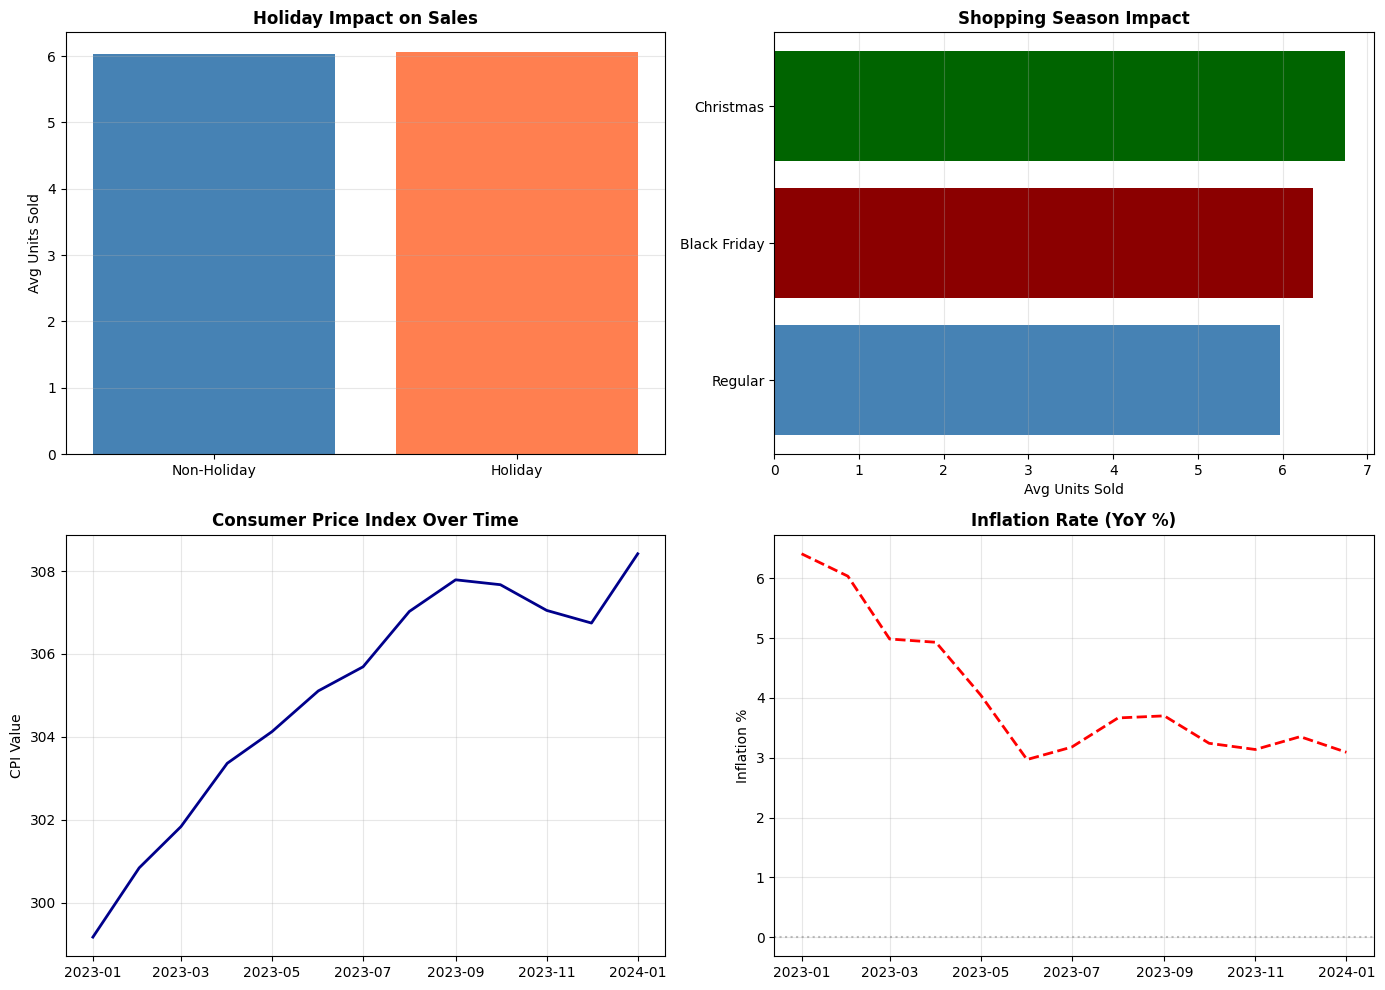

In [7]:
# Visualize exogenous variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Holiday impact
holiday_sales = df.groupby('is_holiday')['units_sold'].mean()
axes[0, 0].bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=['steelblue', 'coral'])
axes[0, 0].set_title('Holiday Impact on Sales', fontweight='bold')
axes[0, 0].set_ylabel('Avg Units Sold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Shopping seasons
season_sales = {
    'Regular': df[(df['is_black_friday_week'] == 0) & (df['is_christmas_season'] == 0)]['units_sold'].mean(),
    'Black Friday': df[df['is_black_friday_week'] == 1]['units_sold'].mean(),
    'Christmas': df[df['is_christmas_season'] == 1]['units_sold'].mean()
}
axes[0, 1].barh(list(season_sales.keys()), list(season_sales.values()), color=['steelblue', 'darkred', 'darkgreen'])
axes[0, 1].set_title('Shopping Season Impact', fontweight='bold')
axes[0, 1].set_xlabel('Avg Units Sold')
axes[0, 1].grid(axis='x', alpha=0.3)

# CPI trend
cpi_monthly = df.groupby(df['date'].dt.to_period('M')).agg({'cpi': 'first', 'cpi_yoy_change': 'first'}).reset_index()
cpi_monthly['date'] = cpi_monthly['date'].dt.to_timestamp()
axes[1, 0].plot(cpi_monthly['date'], cpi_monthly['cpi'], linewidth=2, color='darkblue')
axes[1, 0].set_title('Consumer Price Index Over Time', fontweight='bold')
axes[1, 0].set_ylabel('CPI Value')
axes[1, 0].grid(alpha=0.3)

# Inflation rate
axes[1, 1].plot(cpi_monthly['date'], cpi_monthly['cpi_yoy_change'], linewidth=2, color='red', linestyle='--')
axes[1, 1].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[1, 1].set_title('Inflation Rate (YoY %)', fontweight='bold')
axes[1, 1].set_ylabel('Inflation %')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Time Series Features

**Lag features** and **moving averages** to capture historical patterns.

In [8]:
# Lag features
lag_periods = [1, 2, 3, 7, 14, 21, 30]
for lag in lag_periods:
    df[f'units_sold_lag_{lag}'] = df.groupby(['location_id', 'product_id'])['units_sold'].shift(lag)

# Moving averages
for window in [3, 7, 14, 30]:
    df[f'units_sold_ma_{window}'] = df.groupby(['location_id', 'product_id'])['units_sold'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    df[f'units_sold_std_{window}'] = df.groupby(['location_id', 'product_id'])['units_sold'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )

# Exponential moving averages
for span in [3, 7, 14, 30]:
    df[f'units_sold_ema_{span}'] = df.groupby(['location_id', 'product_id'])['units_sold'].transform(
        lambda x: x.shift(1).ewm(span=span, adjust=False).mean()
    )

print(f'  [OK] Lag features: {len(lag_periods)} periods')
print(f'  [OK] Moving averages: 3, 7, 14, 30 days')
print(f'  [OK] Exponential MAs: 3, 7, 14, 30 days')

  [OK] Lag features: 7 periods
  [OK] Moving averages: 3, 7, 14, 30 days
  [OK] Exponential MAs: 3, 7, 14, 30 days


## 6. Temporal Features

Date-based cyclical features for capturing seasonal patterns.

In [9]:
# Basic temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Cyclical encoding (preserves circular nature of time)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print(f'  [OK] Basic temporal: year, month, quarter, day, week')
print(f'  [OK] Binary indicators: weekend, month start/end')
print(f'  [OK] Cyclical encoding: month and day-of-week (sin/cos)')

# Save intermediate copy before creating targets
print(f'\nDataset before target creation: {df.shape[0]:,} records')

  [OK] Basic temporal: year, month, quarter, day, week
  [OK] Binary indicators: weekend, month start/end
  [OK] Cyclical encoding: month and day-of-week (sin/cos)

Dataset before target creation: 589,340 records


## 7. Target Creation

Create target variable for 1-day ahead forecasting:
- **target**: units_sold 1 day ahead

In [10]:
# Create 1-day ahead target by shifting units_sold
# Negative shift means we look into the future
print('Creating 1-day ahead target...\n')

df['target'] = df.groupby(['product_id', 'location_id'])['units_sold'].shift(-1)

# Check how many NaN values created
print(f'Records before removing NaN target: {len(df):,}')
print(f'  NaN in target: {df["target"].isna().sum():,}')

# Remove rows where target is NaN
df_with_target = df.dropna(subset=['target']).copy()

print(f'\nRecords after removing NaN target: {len(df_with_target):,}')
print(f'Removed: {len(df) - len(df_with_target):,} records')

# Verify target statistics
print(f'\nTarget Statistics:')
print(f'  target - mean: {df_with_target["target"].mean():.2f}, std: {df_with_target["target"].std():.2f}')

# Sanity check: target should correlate with units_sold
print(f'\nCorrelation with units_sold: {df_with_target["units_sold"].corr(df_with_target["target"]):.4f}')

# Update df
df = df_with_target

Creating 1-day ahead target...

Records before removing NaN target: 589,340
  NaN in target: 1,492

Records after removing NaN target: 587,848
Removed: 1,492 records

Target Statistics:
  target - mean: 6.03, std: 24.71

Correlation with units_sold: 0.8415


## 8. Final Preparation & Encoding

Clean remaining NaN values and encode categorical variables.

In [11]:
# Remove rows with too many NaN (from lag features)
# Note: Targets already handled in previous section
df_clean = df[df['units_sold_lag_7'].notna()].copy()
print(f'Rows removed (insufficient history for lags): {len(df) - len(df_clean):,}')

# Fill remaining NaN using forward fill, then backward fill
df_clean = df_clean.ffill().bfill()

# Fill remaining NaN in numeric columns only with 0
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(0)

print(f'Remaining NaN values: {df_clean.isnull().sum().sum()}')

# Categorical encoding (exclude targets from encoding)
cat_cols = ['weather', 'seasonality', 'category', 'region', 'abc', 'fmr', 'data_source']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, prefix=cat_cols, drop_first=False)

print(f'Final dataset: {df_encoded.shape[0]:,} records × {df_encoded.shape[1]} features')
print(f'  Includes 1 target column: target_1d')
print(f'Feature categories:')
print(f'  - Target: 1 (1-day ahead)')
print(f'  - ABC/FMR: 2 analyses')
print(f'  - Exogenous: {len([c for c in df_encoded.columns if "holiday" in c or "cpi" in c or "season" in c.lower()])} features')
print(f'  - Time series: {len([c for c in df_encoded.columns if "lag" in c or "ma_" in c or "ema_" in c or "wma_" in c])} features')
print(f'  - Temporal: {len([c for c in df_encoded.columns if any(x in c for x in ["month", "day", "week", "year", "quarter"])])} features')
print(f'  - Categorical (encoded): {len([c for c in df_encoded.columns if any(x in c for x in cat_cols)])} features')

Rows removed (insufficient history for lags): 10,444
Remaining NaN values: 0
Final dataset: 577,404 records × 82 features
  Includes 1 target column: target_1d
Feature categories:
  - Target: 1 (1-day ahead)
  - ABC/FMR: 2 analyses
  - Exogenous: 12 features
  - Time series: 15 features
  - Temporal: 15 features
  - Categorical (encoded): 27 features


## 9. Save Data

In [12]:
output_zip = 'data/4_engineered_features.zip'
csv_buffer = io.StringIO()
df_encoded.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('engineered_features.csv', csv_buffer.getvalue())